# Online learning of a dictionary of parts of faces

- 이 예제는 얼굴의 큰 데이터셋을 사용하여 얼굴을 구성하는 20 x 20 이미지 패치 세트를 학습한다.
- 이미지를 한 번에 하나씩 로드하고 이 이미지에서 무작위로 50개의 패치를 추출하는 방식으로 진행한다.
- 패치가 500개(이미지 10개 사용) 누적되면 온라인 KMeans 객체인 `MiniBatchKMeans`의 `partial_fit`메서드를 실행한다.
- `MiniBatchKMeans`의 `verbose`설정을 통해 partial_fit에 대한 일부 클러스터가 재할당 되는 것을 볼 수 있다.
    - 패치의 수가 너무 적어지면 새로운 클러스터를 무작위로 선택하는 것이 더 좋기 때문이다.

## Load the data

In [1]:
from sklearn import datasets

faces = datasets.fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Cal-01\scikit_learn_data


## Learn the dictionary of images

In [2]:
import time

import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

print("Learning the dictionary... ")
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=81, random_state=rng, verbose=True, n_init=3)
patch_size = (20, 20)

buffer = []
t0 = time.time()

# The online learning 부분: 전체 데이터셋을 6번 반복한다.
index = 0
for _ in range(6):
    for img in faces.images:
        data = extract_patches_2d(img, patch_size, max_patches=50, random_state=rng)    # 현재 이미지에서 2D패치를 추출한다.  max_patches=50: 각 이미지에서 최대 50개의 패치를 추출한다.
        data = np.reshape(data, (len(data), -1))    # 추출된 패치 데이터를 1차원 배열로 변환한다.
        buffer.append(data)     # 추출된 패치 데이터를 버퍼에 추가한다. 버퍼는 주기적으로 모아진 데이터를 일괄적으로 처리하기 위한 임시 저장소
        index += 1
        if index % 10 == 0:
            data = np.concatenate(buffer, axis=0)   # 버퍼에 저장된 패치 데이터들을 하나의 배열로 합친다.
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)    # 데이터의 각 열에 대해 표준 편차로 나눈다.
            kmeans.partial_fit(data)
            buffer = []
        if index % 100 == 0:
            print("Partial fit of %4i out of %i" % (index, 6 * len(faces.images)))

dt = time.time() - t0
print("done in %.2fs." % dt)

Learning the dictionary... 
[MiniBatchKMeans] Reassigning 8 cluster centers.
[MiniBatchKMeans] Reassigning 5 cluster centers.
Partial fit of  100 out of 2400
[MiniBatchKMeans] Reassigning 3 cluster centers.
Partial fit of  200 out of 2400
[MiniBatchKMeans] Reassigning 1 cluster centers.
Partial fit of  300 out of 2400
[MiniBatchKMeans] Reassigning 3 cluster centers.
Partial fit of  400 out of 2400
Partial fit of  500 out of 2400
Partial fit of  600 out of 2400
Partial fit of  700 out of 2400
Partial fit of  800 out of 2400
Partial fit of  900 out of 2400
Partial fit of 1000 out of 2400
Partial fit of 1100 out of 2400
Partial fit of 1200 out of 2400
Partial fit of 1300 out of 2400
Partial fit of 1400 out of 2400
Partial fit of 1500 out of 2400
Partial fit of 1600 out of 2400
Partial fit of 1700 out of 2400
Partial fit of 1800 out of 2400
Partial fit of 1900 out of 2400
Partial fit of 2000 out of 2400
Partial fit of 2100 out of 2400
Partial fit of 2200 out of 2400
Partial fit of 2300 out

## Plot the results

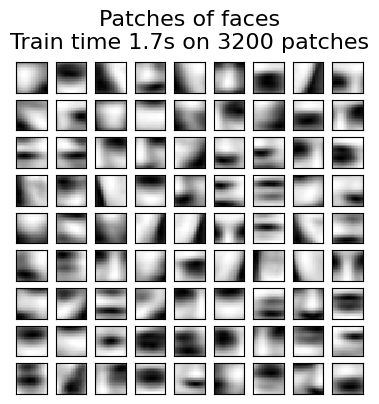

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(9, 9, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())


plt.suptitle(
    "Patches of faces\nTrain time %.1fs on %d patches" % (dt, 8 * len(faces.images)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()